## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from isiparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

%matplotlib inline

/home/izza/.virtualenvs/tacotron2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/izza/.virtualenvs/tacotron2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/izza/.virtualenvs/tacotron2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/izza/.virtualenvs/tacotron2/lib/python3.6/s

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 16000

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Using initial training configurations

#### Load model from checkpoint

In [4]:
checkpoint_path = "checkpoints/checkpoint_1050000"
checkpoint_name = checkpoint_path.split('/')[-1]
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()#cuda().eval().half()

#### Prepare text input and plot results

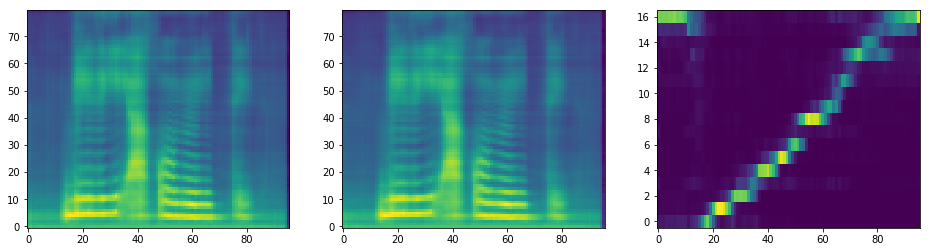

In [20]:
## Prepare text input
text = "Bili ako milk tea"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

## Plot
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

## Synthesis

### Synthesis using Griffin-Lim algorithm

#### Load TacotronSTFT and convert mel-spectrogram to spectrogram

In [21]:
## Get STFT
taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

## Synthesis with Griffin-Lim
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 60)
ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate)

### Synthesis using WaveGlow network

#### Load networks for mel2audio synthesis and denoiser

In [22]:
wavemodel = load_model(hparams)
wavemodel.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = wavemodel.cuda().eval().half()

mel_outputs, mel_outputs_postnet, _, alignments = wavemodel.inference(sequence)

waveglow_path = 'waveglow/checkpoints/waveglow_110000'
wave_name = waveglow_path.split('/')[-1]
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

#### Saving files with librosa

In [12]:
import librosa

## For script
# librosa.output.write_wav('audio/griffin_sentence09.wav',waveform[0].data.cpu().numpy(),hparams.sampling_rate)
# librosa.output.write_wav('audio/wave_sentence09.wav',audio_denoised[0].data.cpu().numpy(),hparams.sampling_rate)

## Randoms
# librosa.output.write_wav('audio/%s_griffin.wav'%checkpoint_name,waveform[0].data.cpu().numpy(),hparams.sampling_rate)
# librosa.output.write_wav('audio/%s_%s_wave.wav'%(checkpoint_name,wave_name),
#                          audio[0].data.cpu().numpy(),hparams.sampling_rate)
# librosa.output.write_wav('audio/%s_%s_denoise.wav'%(checkpoint_name,wave_name),
#                          audio_denoised[0].data.cpu().numpy(),
#                          hparams.sampling_rate)